In [2]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
import cv2
import typing
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib notebook

def reshape_split(image_path: str, kernel_size: tuple):
    image = cv2.imread(image_path)
    img_height, img_width, channels = image.shape
    tile_height, tile_width = kernel_size
    tiled_array = image.reshape(img_height // tile_height,
                               tile_height,
                               img_width // tile_width,
                               tile_width,
                               channels)
    tiled_array = tiled_array.swapaxes(1,2)
    return tiled_array

In [9]:
for dirpath, dirnames, filenames in os.walk('/home/nathaniel/ros_playground/src/vast_data/data'):
    dir_name = dirpath.split('/')[-2]
    if dir_name not in ['mulch', 'brick']:
        print(f'Skipping: f{dirpath}')
        continue
    if len(filenames) > 0 and '.jpg' in filenames[0]:
        # Make a new path directory
        counter = 0
        path_dir = os.path.join(dirpath, 'patches')
        os.makedirs(os.path.join(path_dir),exist_ok=True)
        # Convert and save all patches
        for a_file in tqdm(filenames[::2]):
            patches = reshape_split(os.path.join(dirpath, a_file), (816, 816))
            # Save patches to new directory
            for x in range(patches.shape[0]):
                for y in range(patches.shape[1]):
                    cv2.imwrite(os.path.join(path_dir, f'{str(counter)}.jpg'),patches[x,y,:,:,:])
                    counter += 1

Skipping: f/home/nathaniel/ros_playground/src/vast_data/data
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/mulch


100%|███████████████████████████████████████| 1360/1360 [01:53<00:00, 12.02it/s]


Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_tile-022222-1
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_tile-022222-1/front_right
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_tile-022222-1/front_left
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_tile-022222-1/rear_right
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_tile-022222-1/rear_left
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/concrete
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/concrete/front_right
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/concrete/front_right/patches
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/concrete/front_left
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/concrete/front_left/patches
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/concrete/rear_right
Skipping

100%|███████████████████████████████████████| 1547/1547 [02:12<00:00, 11.68it/s]


Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_concrete-022222-1
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_concrete-022222-1/front_right
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_concrete-022222-1/front_left
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_concrete-022222-1/rear_right
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_concrete-022222-1/rear_left
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_gravel_wet_2022
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_gravel_wet_2022/front_right
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_gravel_wet_2022/front_left
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collection_gravel_wet_2022/rear_right
Skipping: f/home/nathaniel/ros_playground/src/vast_data/data/data_collectio

In [10]:
from datetime import datetime
import numpy as np
import os
import torch
from torch import nn

from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter

LABELS = {
    8: "sand", 
}

K = len(LABELS)

# get data

data_path = '/home/nathaniel/multimodal_terrain_classification/data/'
data = []
labels = []
num_samples = []

for label in LABELS:
    print(LABELS[label])
    for _, dirs, _ in os.walk(data_path):
        for dir in dirs:
            if LABELS[label] in dir:
                for _, _, files in os.walk(data_path + dir):
                    for file in files:
                        if "spectral" in file:
                            data_temp = np.load(data_path + dir + '/' + file)[:,1::2]
                            data_temp = data_temp[np.mean(data_temp, axis=1) > 1800]
                            data.append(data_temp.copy())
                            N = data[-1].shape[0]
                            print(N)
                            labels.append(label * np.ones(N))

spectral_data = np.vstack(data)
spec_copy = spectral_data.copy()
labels_copy = labels.copy()
if spectral_data.shape[1] > 2048:
    spectral_range = torch.tensor(spectral_data[0, 0:spectral_data.shape[1]:2])
    spectral_data = torch.tensor(spectral_data[:, 1:spectral_data.shape[1]:2])

labels = torch.tensor(np.concatenate(labels, axis=0), dtype=torch.int64)
labels = nn.functional.one_hot(labels, num_classes=K).double()
N = spectral_data.shape[0]
data = [[spectral_data[i, :], labels[i]] for i in range(N)]

# find device to train on

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# split data into train/val/test

N_train = int(.6*N)
N_val = int(.2*N)
N_test = N - N_train - N_val
train_data, val_data, test_data = random_split(
    data, [N_train, N_val, N_test], generator=torch.Generator().manual_seed(4)
)

#train_loader = DataLoader(train_data, batch_size=4, num_workers=8, shuffle=True)
#val_loader = DataLoader(val_data, batch_size=4, num_workers=8, shuffle=False)
#test_loader = DataLoader(test_data, batch_size=4, num_workers=8, shuffle=False)


sand
1460
625


RuntimeError: Class values must be smaller than num_classes.

In [12]:
spec_copy

array([[  0.,   0.,   0., ..., 816., 451.,   0.],
       [  0.,   0.,   0., ..., 810., 447.,   0.],
       [  0.,   0.,   0., ..., 814., 445.,   0.],
       ...,
       [  0.,   0.,   0., ..., 852., 472.,   0.],
       [  0.,   0.,   0., ..., 855., 469.,   0.],
       [  0.,   0.,   0., ..., 851., 473.,   0.]])

<IPython.core.display.Javascript object>


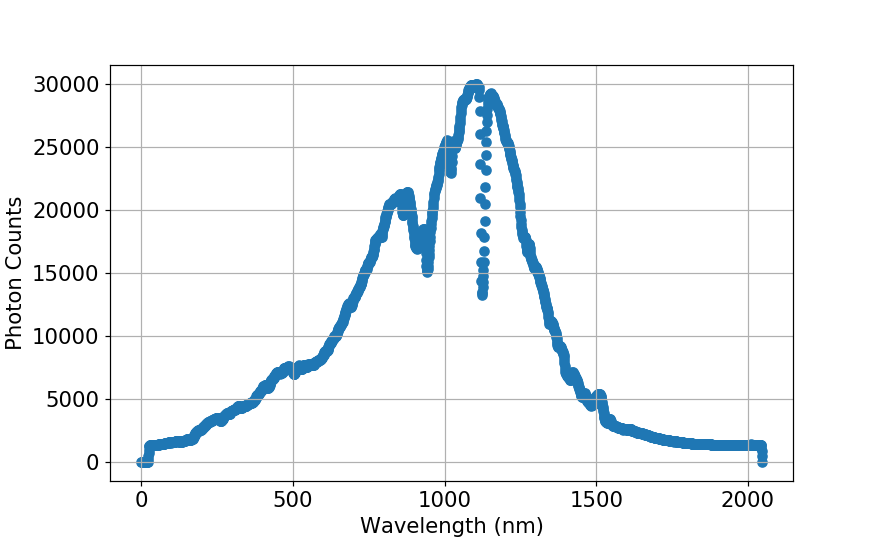

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(range(2048),spec_copy[3,:])
plt.xlabel('Wavelength (nm)',fontsize=14)
plt.ylabel('Photon Counts',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

In [128]:
print(LABELS[labels[10000].argmax().item()])
print(LABELS[labels[100].argmax().item()])
print(LABELS[labels[20009].argmax().item()])
print(LABELS[labels[20049].argmax().item()])
print(LABELS[labels[21000].argmax().item()])
print(LABELS[labels[22000].argmax().item()])


concrete
asphalt
mulch
mulch
sand
sand


In [141]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.predict_proba(X_test[:1])

clf.predict(X_test[:5, :])

clf.score(X_test, y_test)

0.88

In [165]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(spec_copy, out_lab,
                                                    random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.predict_proba(X_test[:1])

clf.predict(X_test[:5, :])

clf.score(X_test, y_test)

0.1954916439953362

In [163]:
spec_copy.shape

(20584, 2048)

In [157]:
out_lab = []
for x  in labels_copy:
    out_lab.extend(list(x.astype('int')))

In [159]:
len(out_lab)

20584